In [ ]:
#from scipy.io import savemat
import time
import math
import numpy as np
import matplotlib.pyplot as plt

# Funciones `create_object` y `compute_normal` deben ser importadas o definidas aquí
from create_object import create_object
from compute_normal import compute_normal
from plot_scene_dual_training_selfOcc import plot_scene_dual_training_selfOcc
from plane_line_intersect import plane_line_intersect
from noise import add_sensor_noise
from noise import add_environmental_noise
from noise import add_shot_noise
#from compute_normal_v2 import compute_normal_v2


In [3]:
# SPAD Camera Params
camera_FOV = 0.25
camera_FOV_center = [0, -camera_FOV / 2, 0]
cam_pixel_dim = 32
bin_size = 390e-12
c = 299792458
FOV_radius = camera_FOV / cam_pixel_dim  

# Laser params
laser_intensity = 1000
laser_pos = np.array([0, 0, 0])
laser_normal = np.array([0, 0, 1])

# Simulation
wall_discr = c / 2 * bin_size / 4
floor_DS = 1

# Room Dimensions (in meters)
xmin, xmax = -3/2, 3/2
ymin, ymax = 0, 3
zmin, zmax = 0, 3

params = {
    'cam_pixel_dim': cam_pixel_dim,
    'camera_FOV': camera_FOV,
    'camera_FOV_center': camera_FOV_center,
    'FOV_radius': FOV_radius,
    'laser_intensity': laser_intensity,
    'bin_size': bin_size,
    'c': c,
    'laser_pos': laser_pos,
    'laser_normal': laser_normal,
    'wall_discr': wall_discr,
}

furthest_scene_point = np.array([xmax, ymax, zmax])
furthest_spad_point = np.array([-params['camera_FOV'] / 2, -params['camera_FOV'], 0])
d1 = np.linalg.norm(furthest_scene_point - laser_pos)
d2 = np.linalg.norm(furthest_spad_point - furthest_scene_point)
max_dist_travel = d1 + d2
num_time_bins = int(np.ceil((max_dist_travel / c / bin_size + 0.2 * max_dist_travel / c / bin_size)))
params['num_time_bins'] = num_time_bins

In [4]:

# Background Objects
objects = []
i = 0

objects.append(create_object(xmin, ymax, 0, xmax - xmin, zmax, 0, 'wall', 'back'))

# Right side wall
i += 1
objects.append(create_object(xmax, ymax, 0, ymax, zmax, -np.pi / 2, 'wall', 'back'))

# Left side wall
i += 1
objects.append(create_object(xmin, ymax, 0, ymax, zmax, -np.pi / 2, 'wall', 'back'))

# Ceiling (added manually with normal vector)
i += 1
objects.append(['wall', np.array([xmin, ymax, zmax]), np.array([xmax - xmin, 0, 0]), np.array([0, -ymax, 0]), np.zeros(3)])
objects = compute_normal(objects, i)

# Simulation Loop
xcoord = [-0.5, 0.5]
ycoord = [1.25, 1.25]

# Función de normalización
nmz = lambda x: x / np.linalg.norm(x)

/home/cristianr/NLOS-Simulator/plot_scene_dual_training_selfOcc.py:8: RuntimeWarning: invalid value encountered in divide
  return x / np.linalg.norm(x)


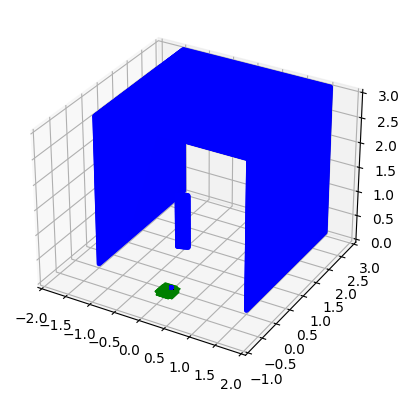

/tmp/ipykernel_1522210/3023076669.py:33: RuntimeWarning: invalid value encountered in divide
  v = params['laser_pos'] / np.sqrt(np.sum(params['laser_pos']**2))
/tmp/ipykernel_1522210/606951529.py:25: RuntimeWarning: invalid value encountered in divide
  nmz = lambda x: x / np.linalg.norm(x)


KeyboardInterrupt: 

In [ ]:

for xx in range(len(xcoord) - 1):
    i = 4  # Cuatro objetos en el fondo (3 paredes + techo)

    params['xcoord'] = xcoord[xx]
    params['ycoord'] = ycoord[xx]

    # Faceta vertical simple (delgada: w=.2; h=1.1;)
    w = 0.2
    h = 1.1
    u = np.array([1, 0, 0])
    v1 = np.array([xcoord[xx], ycoord[xx], 0])
    theta = -np.clip(np.dot(u, v1) / (np.linalg.norm(u) * np.linalg.norm(v1)), -1, 1)
    i += 1
    objects.append(create_object(v1[0], v1[1], v1[2], w, h, theta, 'wall', 'fore'))

    #plt.figure()
    plot_scene_dual_training_selfOcc(params['laser_pos'], objects, params)
    plotFlag = 0 

    # Discretizar la escena en parches
    numpatches = 0
    for o in range(len(objects)):
        numpatches += round(np.linalg.norm(objects[o][2]) / params['wall_discr']) * round(np.linalg.norm(objects[o][3]) / params['wall_discr'])

    # Preasignar matrices
    scene_pixel = np.zeros((int(np.ceil(numpatches)), 3))
    scene_pixel_normal = np.zeros((int(np.ceil(numpatches)), 3))
    scene_pixel_area = (params['wall_discr'])**2
    scene_pixel_angle = 1000 * np.ones(int(np.ceil(numpatches)))

    #v = nmz(laser_pos[:2])
    v = params['laser_pos'] / np.sqrt(np.sum(params['laser_pos']**2))
    light_angle = v[0]
    patch_count = 0

    for o in range(len(objects)):
        for i in np.linspace(0, 1, round(np.linalg.norm(objects[o][2]) / params['wall_discr'])):
            for j in np.linspace(0, 1, round(np.linalg.norm(objects[o][3]) / params['wall_discr'])):
                if objects[o][1][2] + i * objects[o][2][2] + j * objects[o][3][2] > 0:
                    pos = [  
                           objects[o][1][0] + i * objects[o][2][0] + j * objects[o][3][0],
                           objects[o][1][1] + i * objects[o][2][1] + j * objects[o][3][1],
                           objects[o][1][2] + i * objects[o][2][2] + j * objects[o][3][2]
                           ]
                    oc = False

                    if o <= 3:
                        for k in range(4, len(objects)):
                            I, check = plane_line_intersect(objects[k][4], objects[k][1], params['laser_pos'], pos)
                            A = objects[k][1]
                            B = objects[k][1] + objects[k][2]
                            C = objects[k][1] + objects[k][3]
                            D = objects[k][1] + objects[k][2] + objects[k][3]
                            quad = np.array([A, B, D, C])

                            if check == 1:
                                mi = np.min(quad, axis=0)
                                ma = np.max(quad, axis=0)
                                T = (I[0] >= mi[0]) and (I[0] <= ma[0]) and \
                                    (I[1] >= mi[1]) and (I[1] <= ma[1]) and \
                                    (I[2] >= mi[2]) and (I[2] <= ma[2])

                                if T:
                                    oc = True
                                    break

                    v = nmz(pos[0:2])
                    scene_pixel_angle = -v[0]
                    if -scene_pixel_angle + light_angle < 0:
                        oc = True

                    if not oc:
                        scene_pixel[patch_count, :] = pos
                        scene_pixel_normal[patch_count, :] = objects[o][4]
                        patch_count += 1

    # Encuentra los centros de los píxeles de la cámara/suelo
    pixel_x = np.linspace(params['camera_FOV_center'] [0] - params['camera_FOV']  / 2 + params['camera_FOV']  / (2 * params['cam_pixel_dim']),
                          params['camera_FOV_center'] [0] + params['camera_FOV']  / 2 - params['camera_FOV']  / (2 * params['cam_pixel_dim']), params['cam_pixel_dim'])
    pixel_y = np.linspace(params['camera_FOV_center'] [1] - params['camera_FOV']  / 2 + params['camera_FOV']  / (2 * params['cam_pixel_dim']),
                             params['camera_FOV_center'] [1] + params['camera_FOV']  / 2 - params['camera_FOV']  / (2 * params['cam_pixel_dim']), params['cam_pixel_dim'])

    pixel_t = np.linspace(0, (params['num_time_bins'] - 1) * params['bin_size'], params['num_time_bins'])

    X, Y = np.meshgrid(pixel_x, pixel_y, indexing='xy')
    cam_pos = np.vstack([X.ravel(), Y.ravel(), np.zeros(params['cam_pixel_dim']**2)]).T

    X_ind, Y_ind = np.meshgrid(range(params['cam_pixel_dim']), range(params['cam_pixel_dim']), indexing='xy')
    cam_pos_ind = np.vstack([X_ind.ravel(), Y_ind.ravel()]).T

    X, Y, T = np.meshgrid(pixel_x, pixel_y, pixel_t)
    cam_pixel = np.vstack([X.ravel(), Y.ravel(), T.ravel()]).T

    # Forma la medición correspondiente
    y_meas_vec = np.zeros(cam_pixel.shape[0])

    fourpi = 4 * np.pi * np.pi
    floor_normal = np.array([0, 0, 1])
    floor_pixel_width = params['camera_FOV'] / params['cam_pixel_dim']

    spix = scene_pixel.shape[0]
    for sp in range(spix):
        scene_center = scene_pixel[sp, :]
        m = (scene_center[1] - cam_pos[:, 1]) / (scene_center[0] - cam_pos[:, 0])
        b = scene_center[1] - np.dot(m, scene_center[0])
        xint = -b / m

        noc = xint > 0
        if np.sum(noc) > 0:
            lps = params['laser_pos'] - scene_center
            fovsp = cam_pos[noc, :] - scene_center

            d1s = np.sum(lps**2)
            d2s = np.sum(fovsp**2, axis=1)
            d1 = np.sqrt(d1s)
            d2 = np.sqrt(d2s)
            distance = d1 + d2
            tbin = distance / (c * params['bin_size'])
            arrival_bin = np.ceil(tbin).astype(int)

            dot1 = np.maximum(0, np.sum(np.dot(scene_pixel_normal[sp, :], lps / d1))) 
            dot2 = np.maximum(0, np.sum(scene_pixel_normal[sp, :] * fovsp / d2[:, np.newaxis], axis=1))            
            dot3 = np.maximum(0, np.sum(np.dot(params['laser_normal'], -lps / d1)))  
            dot4 = np.maximum(0, np.sum(floor_normal * -fovsp / d2[:, np.newaxis], axis=1))

            intensity = params['laser_intensity'] * scene_pixel_area * (dot1 * dot2 * dot3 * dot4) / (fourpi * d1s * d2s)

            coord = np.dot(arrival_bin - 1, params['cam_pixel_dim']**2) + np.dot((cam_pos_ind[noc, 0] - 1), params['cam_pixel_dim']) + cam_pos_ind[noc, 1]
            y_meas_vec[coord] += intensity

            if sp % 50000 == 0:
                print(f"{100 * sp / spix:.2f}%, t={time.time()}")

    
    y_meas_vec = y_meas_vec.reshape((params['cam_pixel_dim'], params['cam_pixel_dim'], params['num_time_bins']), order='F')
    
    plt.figure()
    plt.plot(np.squeeze(y_meas_vec[0, 0, :]))
    plt.show() 
    
    y_sum = np.sum(y_meas_vec, axis=2)

    y_sum = np.roll(y_sum, shift=1, axis=-1)

    plt.imshow(y_sum, cmap='viridis')
    plt.colorbar()
    plt.title('Suma a través de la tercera dimensión')
    plt.show()
    
    #filename = f"Video_{int(params['bin_size'] * 1e12)}ps_ThinFacet_pos_{xx}.mat"
    #savemat(filename, {'params': params, 'y_meas_vec': y_meas_vec, 'objects': objects})
